# Analysis of Solomon 8.15.18 MOES Quantitative Data Final


## Class panda_reader()
## Utility class to get a panda df from Excel

In [3]:
import pandas as pd
import numpy as np
import unittest
import logging
import os.path
from pandas.util.testing import assert_frame_equal
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

class panda_reader():
    filename = None
    worksheetname = None
    df = None

    # Getters and setters for filename, worksheetname, and df
    def getFilename(self):
        if self.filename is None:
            logger.info('filename is not yet set!!')
            return None
        else:
            logger.debug('About to return current filename, which is: ' + self.filename)
        
        return self.filename
        
    # Setter for filename. Returns True if the file was found, False otherwise. 
    # Results can be disregarded if you are writing the file. 
    def setFilename(self, fn):
        logger.debug('About to set filename to: ' + fn)
        self.filename = fn
        if not os.path.isfile(fn):
            logger.warning('Cannot find file ' + fn)
            return False
        return True

        
    def getWorksheetName(self):
        return self.worksheetname
    
    def setWorksheetName(self, wks):
        logger.debug('About to set worksheet to: ' + wks)
        self.worksheetname = wks
        
    def getDf(self):
        return self.df

    # Return a tiny test dataframe
    def test_df(self):
        data = np.array([['','Col1','Col2'],
                         ['Row1',1,2],
                         ['Row2',3,4]])
                
        return (pd.DataFrame(data=data[1:,1:], index=data[1:,0], columns=data[0,1:]))
    
    # Write the given df to the excelFileName and excelWorksheet (unless they have already been 
    # provided and are then optional.)
    def write_df_to_excel(self, df=None, excelFileName=None, excelWorksheet=None):
        # Use df (passed param) if it's set, self.df otherwise.
        if df is None:
            mydf = self.df
        else:
            mydf = df
        fn  = excelFileName or self.filename # If excelFileName is set, then use it. If None, then use self.filename.
        wks = excelWorksheet or self.worksheetname # Use the passed excelWorksheet, if available. 
        self.setFilename(fn)
        self.setWorksheetName(wks)
        writer = pd.ExcelWriter(fn)
        mydf.to_excel(writer, wks)
        writer.save()
        
    # Read the given excelFileName and excelWorksheet (unless they have already been 
    # provided and are then optional.) return the df in the given worksheet. 
    def read_df_from_excel(self, excelFileName=None, excelWorksheet=None, header=0):
        logger.debug("Starting read_df_from_excel")
        fn = excelFileName or self.filename
        fileFound = self.setFilename(fn)
        logger.debug("Will read from the Excel file: " + fn)
        if fileFound:
            wks = excelWorksheet or self.worksheetname
            self.setWorksheetName(excelWorksheet)
            logger.debug("Will read from the worksheet: " + wks)
            self.df = pd.read_excel(fn, sheet_name=wks, header=header)

            return self.df
        else:
            logger.error("Can't find Excel file: " + fn)
            return None
        
    # Get a list of the headers
    def get_df_headers(self):
        if self.df is not None:
            return self.df.columns.tolist()
        else:
            logger.error("df is empty. Returning None for headers.")
            return None


# stats
### Utility class to plot and get basic statistics

In [4]:
import seaborn as sns
from scipy.stats import linregress

class stats():
    def plot_and_stats(self, df, xlabel, ylabel, color='r'):
        sns.regplot(x=xlabel, y=ylabel, data=df, robust=True, color=color, x_jitter=1.0, y_jitter=1.0)

        slope, intercept, r, p, epsilon = linregress(df[xlabel], df[ylabel])
        logger.info('Main equation: y = %.3f x + %.3f' % (slope, intercept))
        logger.info('r^2 = %.4f' % (r * r))
        logger.info('p = %.4f' % (p))
        logger.info('std err: %.4f' % (epsilon))


# Main routine to read MOES spreadsheet

In [5]:

import logging
import os.path
import numpy as np
import pandas as pd

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

fn = 'MOES_Quantitative_Data_Final_25Aug18.xlsx'

def remove_df_headers(df, rows_to_remove=1):
    return df.iloc[rows_to_remove:] # get rid of verbose headers (usually in row 2 of the Excel worksheet)
    

def massage_df(df, headers):
    ansDf =  remove_df_headers(df)
#    ansDf[['X1', 'X2']] = ansDf[['X1', 'X2']].apply(pd.to_numeric())
    non_numeric_cols_to_remove = ['Participant', 'date_survey_taken', 'Gender', 'Age', 'Ethnicity', 'Education', 'Branch', 'Campaigns']
    for col in non_numeric_cols_to_remove:
        headers.remove(col)
    ansDf[headers] = ansDf[headers].apply(pd.to_numeric, errors='coerce')

    return ansDf

if __name__ == '__main__':
    logger.info('Starting main')
    my_lib = panda_reader()
    if my_lib.setFilename(fn):
        logger.debug('Found the file')
    else:
        logger.debug('did not find the file')
    raw_df = my_lib.read_df_from_excel(excelFileName=fn, excelWorksheet='Minus Partial Completions')
    df = massage_df(raw_df, my_lib.get_df_headers())
    
    df.dropna(inplace=True) # Gets rid of NaN
    logger.debug('Spreadsheet read in.')


INFO:__main__:Starting main
DEBUG:__main__:About to set filename to: MOES_Quantitative_Data_Final_25Aug18.xlsx
DEBUG:__main__:Found the file
DEBUG:__main__:Starting read_df_from_excel
DEBUG:__main__:About to set filename to: MOES_Quantitative_Data_Final_25Aug18.xlsx
DEBUG:__main__:Will read from the Excel file: MOES_Quantitative_Data_Final_25Aug18.xlsx
DEBUG:__main__:About to set worksheet to: Minus Partial Completions
DEBUG:__main__:Will read from the worksheet: Minus Partial Completions
C:\Users\Owner\Anaconda2\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\Owner\Anaconda2\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

# First five lines of data

In [6]:
df.head(5)

,index,Participant,date_survey_taken,date_between_survey,page1,page2,page3,X1,X2,X3,...,Y10,Y,delta_Y,Gender,Age,decade_age,Ethnicity,Education,Branch,Campaigns
1,0.0,3e6038ab-3ce6-4cf3-bcef-3fcd71a38712,2016-04-23 18:32:00,184.812500,125.588549,74.088909,71.542415,2.0,2.0,3.0,...,3.0,35,1.0,Male,65-74 years old,6.0,White,"Some college credit, no degree",Army,",,,Vietnam,,"
3,2.0,6303bc10-ff60-48a1-81a9-be8b37ea7fcd,2016-05-14 21:47:00,188.180556,160.135799,47.026560,34.229927,2.0,0.0,0.0,...,4.0,39,0.0,Male,25-34 years old,2.0,White,"Some college credit, no degree",Marine Corps,"OperationEnduringFreedom,OperationIraqiFreedom..."
5,4.0,49694f11-0d24-4bd6-aa96-43a5c7872262,2016-05-15 07:56:00,197.400000,251.571578,130.025017,127.525612,3.0,3.0,1.0,...,3.0,31,4.0,Male,25-34 years old,2.0,Hispanic or Latino,"Some college credit, no degree",Marine Corps,",OperationIraqiFreedom,,,,"
7,6.0,1639567d-947e-4c3b-89dd-c801bf39a0ab,2016-06-07 22:17:00,224.729167,199.842927,82.874621,42.343850,3.0,3.0,3.0,...,1.0,10,0.0,Male,45-54 years old,4.0,Hispanic or Latino,Associate degree,Army,"OperationEnduringFreedom,,DesertStorm,,,"
9,8.0,e4f6fd3e-3fde-441d-bd20-ac32c1638035,2016-06-09 06:43:00,197.159722,439.121549,61.728797,45.962699,1.0,1.0,1.0,...,3.0,36,4.0,Male,35-44 years old,3.0,White,"Some college credit, no degree",Army,"OperationEnduringFreedom,OperationIraqiFreedom..."


## First graph: Change in PTSD markers

INFO:__main__:X=change in PTSD; Y=change in faith. n=48


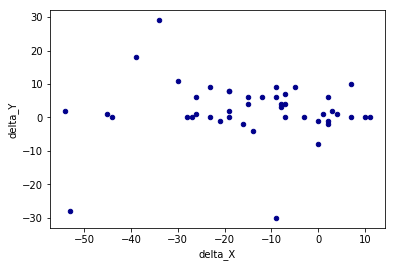

In [7]:
# df.dtypes
logger.info('X=change in PTSD; Y=change in faith. n=' + str(df.shape[1]))
df.plot.scatter(x='delta_X', y='delta_Y', c='DarkBlue')


## Aggregate changes
#### Independent (x) axis is change in PTSD. An aggregate drop of 5-10 points is reliable (not due to chance). An aggregate drop of 10-20 is clinically meaningful. (Monson et al., 2008).
#### Dependent (y) axis is change in faith. 

INFO:__main__:Main equation: y = -0.010 x + 1.996
INFO:__main__:r^2 = 0.0003
INFO:__main__:p = 0.9103
INFO:__main__:std err: 0.0845


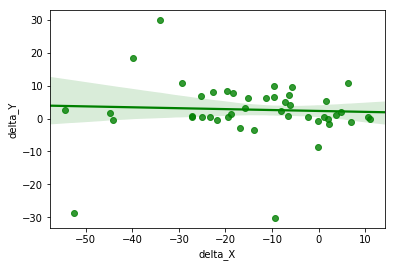

In [8]:
stat = stats()
stat.plot_and_stats(df=df, xlabel='delta_X', ylabel='delta_Y', color='g')

# In the survey, a 0 means "no answer"
The scale is 1-4, with 0 meaning "no answer."
This may explain some of the very negative deltas.
## select
This routine is like a select statement for dataframes. 
## adjust_zero
### Overview
This routine replaces 0 answers in the DF with the previous answer.
### One response > 0, other = 0
If the respondent had a 1 for first response of "Repeated, disturbing dreams of the stressful experience?" and a 0 for the second, the second will be changed to a 1.
This will create a net change of 0 for the response.
### Both responses 0
If the responded had a 0 for both responses of "I pray daily" then an average of the non-zero responses for the first response will be calculated. The first and second will be set to that average.
This will also create a net change of 0 for the response.

## adjust_sum
This routine adjusts the sums for the Xs or Ys after adjust_zero has been executed on both vectors.

## adjust_delta
This routine calculates a new delta_X and delta_Y.



In [9]:
def XYnGen(label='X', start=1, end=20):
    # Generator like X1 through X20
    for x in range (start, end+1):
        yield '%s%d' % (label, x)

    
def select(df, columnName, matchMe):
    return df.loc[df[columnName] == matchMe]

def non_zero_avg(df, rowIndex, headers):
    logger.debug('Examining row %d' % rowIndex)
    
    row = df.iloc[rowIndex]
    df1 = row[headers]
    vector_sum = df1.sum()
    values = df1.tolist()
    logger.debug('values: ' + str(values))
    zero_count = values.count(0)
    avg = (vector_sum * 1.0) / (len(df1) - zero_count) # note if no 0s, will compute average from all
    logger.debug('Zero count: %d. Average=%f' % (zero_count, avg))
    return avg

def adjust_rows(df, row1index, row2index, nonZeroAvg, headers):
    logger.debug('Starting adjust_rows; comparing rows %d and %d.' % (row1index, row2index))
    row1 = df.iloc[row1index]
    row2 = df.iloc[row2index]
    for header in headers:
        cell1 = row1[header]
        cell2 = row2[header]
        logger.debug('comparing header %s with values %d and %d.' % (header, cell1, cell2))
        if (cell1 != 0) & (cell2 != 0):
            pass # neither is 0.
        elif (cell1 == 0) & (cell2 == 0):
            logger.debug('Setting both values to %f.' % nonZeroAvg)
            rowsToChange = [row1index, row2index]
            df.loc[rowsToChange, header] = nonZeroAvg
        elif (cell1 == 0):
            logger.debug('Setting row %d to %d.' % (row1index, cell2))
            df.loc[row1index, header] = cell2
        else:
            logger.debug('Setting row %d to %d.' % (row2index, cell1))
            df.loc[row2index, header] = cell1
            
def adjust_sum(df, rowIndex, sumLabel, headers):
    logger.debug('Starting adjust_sum for rows %d.' % rowIndex)
    row = df.iloc[rowIndex]
    s = row[headers].sum()
    df.loc[rowIndex, sumLabel] = s
    logger.debug('Exiting adjust_sum with a sum of %f.' % s)
    return s

def adjust_delta(df, row1index, row2index, sumLabel, deltaLabel):
    df.loc[row1index, deltaLabel] = float('NaN')
    diff= df.loc[row2index, sumLabel] - df.loc[row1index, sumLabel]
    df.loc[row2index, deltaLabel] = diff
    logger.debug('Exiting adjust_delta with row %d set to NaN and row %d set to %f.' % (row1index, row2index, diff))
    
    
def adjust_zero(df, subsetdf):
    logger.debug("Starting adjust_zero. Full set has %d rows. Subset has %d results." % (len(df), len(subsetdf)))
    xgen = XYnGen('X', 1, 20) # generates 'X1' through 'X20'
    ygen = XYnGen('Y', 1, 10) # generates 'Y1' through 'Y10'
    row1 = subsetdf.iloc[0]
    row2 = subsetdf.iloc[1]
    row1index = row1['index']
    row2index = row2['index']
    logger.debug('Comparing rows %d and %d.' % (row1index, row2index))
    xHeaders = list(xgen)
    yHeaders = list(ygen)
    nonZeroXAvg = non_zero_avg(df, row1index, xHeaders) 
    nonZeroYAvg = non_zero_avg(df, row1index, yHeaders)
    
    adjust_rows(df, row1index, row2index, nonZeroXAvg, xHeaders)
    adjust_rows(df, row1index, row2index, nonZeroYAvg, yHeaders)
    
    adjust_sum(df, row1index, 'X', xHeaders)
    adjust_sum(df, row2index, 'X', xHeaders)
    adjust_sum(df, row1index, 'Y', yHeaders)
    adjust_sum(df, row2index, 'Y', yHeaders)
    adjust_delta(df, row1index, row2index, 'X', 'delta_X')
    adjust_delta(df, row1index, row2index, 'Y', 'delta_Y')
    
    return df

def process_participants(df):
    indexColName = 'Participant'
    participants = df.Participant.unique()
    for participant in participants:
        logger.debug("Processing participant: " + participant)
        results = select(df, indexColName, participant)
        adjust_zero(df, results)
    return


In [10]:
df = remove_df_headers(raw_df, 1)
df.set_index('index') # Set the index 
df.dropna(axis=0, subset=['index'], inplace=True)
df = df.reset_index(drop=True)
process_participants(df)
df.head()

C:\Users\Owner\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
DEBUG:__main__:Processing participant: 3e6038ab-3ce6-4cf3-bcef-3fcd71a38712
DEBUG:__main__:Starting adjust_zero. Full set has 90 rows. Subset has 2 results.
DEBUG:__main__:Comparing rows 0 and 1.
DEBUG:__main__:Examining row 0
DEBUG:__main__:values: [2, 2, 3, 3, 2, 2, 1, 2, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4, 4, 4]
DEBUG:__main__:Zero count: 0. Average=2.950000
DEBUG:__main__:Examining row 0
DEBUG:__main__:values: [4, 3, 4, 4, 2, 4, 3, 4, 4, 3]
DEBUG:__main__:Zero count: 0. Average=3.500000
DEBUG:__main__:Starting adjust_rows; comparing rows 0 and 1.
DEBUG:__main__:comparing header X1 with values 2 and 1.
DEBUG:__main__:comparing head

DEBUG:__main__:Starting adjust_rows; comparing rows 4 and 5.
DEBUG:__main__:comparing header Y1 with values 3 and 3.
DEBUG:__main__:comparing header Y2 with values 4 and 4.
DEBUG:__main__:comparing header Y3 with values 3 and 3.
DEBUG:__main__:comparing header Y4 with values 3 and 3.
DEBUG:__main__:comparing header Y5 with values 3 and 4.
DEBUG:__main__:comparing header Y6 with values 3 and 4.
DEBUG:__main__:comparing header Y7 with values 3 and 4.
DEBUG:__main__:comparing header Y8 with values 3 and 3.
DEBUG:__main__:comparing header Y9 with values 3 and 3.
DEBUG:__main__:comparing header Y10 with values 3 and 4.
DEBUG:__main__:Starting adjust_sum for rows 4.
DEBUG:__main__:Exiting adjust_sum with a sum of 49.000000.
DEBUG:__main__:Starting adjust_sum for rows 5.
DEBUG:__main__:Exiting adjust_sum with a sum of 42.000000.
DEBUG:__main__:Starting adjust_sum for rows 4.
DEBUG:__main__:Exiting adjust_sum with a sum of 31.000000.
DEBUG:__main__:Starting adjust_sum for rows 5.
DEBUG:__main_

DEBUG:__main__:comparing header X8 with values 1 and 1.
DEBUG:__main__:comparing header X9 with values 1 and 1.
DEBUG:__main__:comparing header X10 with values 1 and 1.
DEBUG:__main__:comparing header X11 with values 3 and 1.
DEBUG:__main__:comparing header X12 with values 3 and 1.
DEBUG:__main__:comparing header X13 with values 3 and 1.
DEBUG:__main__:comparing header X14 with values 3 and 1.
DEBUG:__main__:comparing header X15 with values 3 and 1.
DEBUG:__main__:comparing header X16 with values 0 and 0.
DEBUG:__main__:Setting both values to 2.210526.
DEBUG:__main__:comparing header X17 with values 3 and 2.
DEBUG:__main__:comparing header X18 with values 2 and 0.
DEBUG:__main__:Setting row 11 to 2.
DEBUG:__main__:comparing header X19 with values 4 and 1.
DEBUG:__main__:comparing header X20 with values 3 and 2.
DEBUG:__main__:Starting adjust_rows; comparing rows 10 and 11.
DEBUG:__main__:comparing header Y1 with values 2 and 3.
DEBUG:__main__:comparing header Y2 with values 2 and 3.
DE

DEBUG:__main__:Starting adjust_zero. Full set has 90 rows. Subset has 2 results.
DEBUG:__main__:Comparing rows 16 and 17.
DEBUG:__main__:Examining row 16
DEBUG:__main__:values: [4, 4, 3.0, 4, 3, 3, 4, 3, 1, 4, 4, 3, 3, 3, 3, 1.0, 2, 2, 4, 4]
DEBUG:__main__:Zero count: 0. Average=3.100000
DEBUG:__main__:Examining row 16
DEBUG:__main__:values: [4, 3, 4, 4, 3, 4, 4, 4, 4, 3]
DEBUG:__main__:Zero count: 0. Average=3.700000
DEBUG:__main__:Starting adjust_rows; comparing rows 16 and 17.
DEBUG:__main__:comparing header X1 with values 4 and 4.
DEBUG:__main__:comparing header X2 with values 4 and 3.
DEBUG:__main__:comparing header X3 with values 3 and 2.
DEBUG:__main__:comparing header X4 with values 4 and 4.
DEBUG:__main__:comparing header X5 with values 3 and 3.
DEBUG:__main__:comparing header X6 with values 3 and 3.
DEBUG:__main__:comparing header X7 with values 4 and 3.
DEBUG:__main__:comparing header X8 with values 3 and 2.
DEBUG:__main__:comparing header X9 with values 1 and 4.
DEBUG:__mai

DEBUG:__main__:comparing header Y9 with values 3 and 3.
DEBUG:__main__:comparing header Y10 with values 3 and 3.
DEBUG:__main__:Starting adjust_sum for rows 20.
DEBUG:__main__:Exiting adjust_sum with a sum of 51.000000.
DEBUG:__main__:Starting adjust_sum for rows 21.
DEBUG:__main__:Exiting adjust_sum with a sum of 31.000000.
DEBUG:__main__:Starting adjust_sum for rows 20.
DEBUG:__main__:Exiting adjust_sum with a sum of 31.000000.
DEBUG:__main__:Starting adjust_sum for rows 21.
DEBUG:__main__:Exiting adjust_sum with a sum of 30.000000.
DEBUG:__main__:Exiting adjust_delta with row 20 set to NaN and row 21 set to -20.000000.
DEBUG:__main__:Exiting adjust_delta with row 20 set to NaN and row 21 set to -1.000000.
DEBUG:__main__:Processing participant: 761495a9-0691-47e7-864f-ea3a2190c2c2
DEBUG:__main__:Starting adjust_zero. Full set has 90 rows. Subset has 2 results.
DEBUG:__main__:Comparing rows 22 and 23.
DEBUG:__main__:Examining row 22
DEBUG:__main__:values: [2, 2, 3.0, 4, 3, 4, 4, 1, 2,

DEBUG:__main__:Processing participant: 40db83e0-532a-47bf-b89e-d9fbea784750
DEBUG:__main__:Starting adjust_zero. Full set has 90 rows. Subset has 2 results.
DEBUG:__main__:Comparing rows 26 and 27.
DEBUG:__main__:Examining row 26
DEBUG:__main__:values: [3, 0, 3.0, 3, 3, 3, 3, 0, 2, 2.0, 2.0, 2.0, 3, 2, 2, 1.0, 3, 3, 3, 3]
DEBUG:__main__:Zero count: 2. Average=2.555556
DEBUG:__main__:Examining row 26
DEBUG:__main__:values: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
DEBUG:__main__:Zero count: 0. Average=3.000000
DEBUG:__main__:Starting adjust_rows; comparing rows 26 and 27.
DEBUG:__main__:comparing header X1 with values 3 and 2.
DEBUG:__main__:comparing header X2 with values 0 and 1.
DEBUG:__main__:Setting row 26 to 1.
DEBUG:__main__:comparing header X3 with values 3 and 1.
DEBUG:__main__:comparing header X4 with values 3 and 2.
DEBUG:__main__:comparing header X5 with values 3 and 1.
DEBUG:__main__:comparing header X6 with values 3 and 1.
DEBUG:__main__:comparing header X7 with values 3 and 1.
DEBUG

DEBUG:__main__:comparing header Y8 with values 3 and 1.
DEBUG:__main__:comparing header Y9 with values 2 and 1.
DEBUG:__main__:comparing header Y10 with values 1 and 1.
DEBUG:__main__:Starting adjust_sum for rows 30.
DEBUG:__main__:Exiting adjust_sum with a sum of 52.000000.
DEBUG:__main__:Starting adjust_sum for rows 31.
DEBUG:__main__:Exiting adjust_sum with a sum of 52.000000.
DEBUG:__main__:Starting adjust_sum for rows 30.
DEBUG:__main__:Exiting adjust_sum with a sum of 18.000000.
DEBUG:__main__:Starting adjust_sum for rows 31.
DEBUG:__main__:Exiting adjust_sum with a sum of 10.000000.
DEBUG:__main__:Exiting adjust_delta with row 30 set to NaN and row 31 set to 0.000000.
DEBUG:__main__:Exiting adjust_delta with row 30 set to NaN and row 31 set to -8.000000.
DEBUG:__main__:Processing participant: ff8cccea-ffab-443d-9f02-47997ffa143d
DEBUG:__main__:Starting adjust_zero. Full set has 90 rows. Subset has 2 results.
DEBUG:__main__:Comparing rows 32 and 33.
DEBUG:__main__:Examining row 3

DEBUG:__main__:Setting both values to 2.066667.
DEBUG:__main__:comparing header X15 with values 0 and 0.
DEBUG:__main__:Setting both values to 2.066667.
DEBUG:__main__:comparing header X16 with values 1 and 0.
DEBUG:__main__:Setting row 37 to 1.
DEBUG:__main__:comparing header X17 with values 2 and 3.
DEBUG:__main__:comparing header X18 with values 2 and 1.
DEBUG:__main__:comparing header X19 with values 1 and 0.
DEBUG:__main__:Setting row 37 to 1.
DEBUG:__main__:comparing header X20 with values 2 and 1.
DEBUG:__main__:Starting adjust_rows; comparing rows 36 and 37.
DEBUG:__main__:comparing header Y1 with values 3 and 3.
DEBUG:__main__:comparing header Y2 with values 3 and 1.
DEBUG:__main__:comparing header Y3 with values 4 and 3.
DEBUG:__main__:comparing header Y4 with values 3 and 2.
DEBUG:__main__:comparing header Y5 with values 1 and 2.
DEBUG:__main__:comparing header Y6 with values 2 and 1.
DEBUG:__main__:comparing header Y7 with values 4 and 4.
DEBUG:__main__:comparing header Y8 

DEBUG:__main__:Starting adjust_zero. Full set has 90 rows. Subset has 2 results.
DEBUG:__main__:Comparing rows 42 and 43.
DEBUG:__main__:Examining row 42
DEBUG:__main__:values: [2, 2, 0.0, 0.0, 2, 3, 3, 3, 4, 4.0, 3.0, 3.0, 3, 3.0, 4.0, 4.0, 3, 2, 1, 2]
DEBUG:__main__:Zero count: 2. Average=2.833333
DEBUG:__main__:Examining row 42
DEBUG:__main__:values: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
DEBUG:__main__:Zero count: 0. Average=4.000000
DEBUG:__main__:Starting adjust_rows; comparing rows 42 and 43.
DEBUG:__main__:comparing header X1 with values 2 and 1.
DEBUG:__main__:comparing header X2 with values 2 and 1.
DEBUG:__main__:comparing header X3 with values 0 and 0.
DEBUG:__main__:Setting both values to 2.833333.
DEBUG:__main__:comparing header X4 with values 0 and 0.
DEBUG:__main__:Setting both values to 2.833333.
DEBUG:__main__:comparing header X5 with values 2 and 0.
DEBUG:__main__:Setting row 43 to 2.
DEBUG:__main__:comparing header X6 with values 3 and 0.
DEBUG:__main__:Setting row 43 to 3.

DEBUG:__main__:comparing header X19 with values 3 and 2.
DEBUG:__main__:comparing header X20 with values 3 and 2.
DEBUG:__main__:Starting adjust_rows; comparing rows 46 and 47.
DEBUG:__main__:comparing header Y1 with values 2 and 3.
DEBUG:__main__:comparing header Y2 with values 2 and 2.
DEBUG:__main__:comparing header Y3 with values 2 and 3.
DEBUG:__main__:comparing header Y4 with values 2 and 3.
DEBUG:__main__:comparing header Y5 with values 2 and 3.
DEBUG:__main__:comparing header Y6 with values 2 and 3.
DEBUG:__main__:comparing header Y7 with values 2 and 3.
DEBUG:__main__:comparing header Y8 with values 2 and 3.
DEBUG:__main__:comparing header Y9 with values 2 and 3.
DEBUG:__main__:comparing header Y10 with values 2 and 3.
DEBUG:__main__:Starting adjust_sum for rows 46.
DEBUG:__main__:Exiting adjust_sum with a sum of 52.411765.
DEBUG:__main__:Starting adjust_sum for rows 47.
DEBUG:__main__:Exiting adjust_sum with a sum of 29.411765.
DEBUG:__main__:Starting adjust_sum for rows 46.


DEBUG:__main__:comparing header X5 with values 3 and 1.
DEBUG:__main__:comparing header X6 with values 4 and 2.
DEBUG:__main__:comparing header X7 with values 4 and 2.
DEBUG:__main__:comparing header X8 with values 4 and 3.
DEBUG:__main__:comparing header X9 with values 2 and 1.
DEBUG:__main__:comparing header X10 with values 3 and 1.
DEBUG:__main__:comparing header X11 with values 2 and 1.
DEBUG:__main__:comparing header X12 with values 2 and 1.
DEBUG:__main__:comparing header X13 with values 3 and 1.
DEBUG:__main__:comparing header X14 with values 3 and 1.
DEBUG:__main__:comparing header X15 with values 3 and 2.
DEBUG:__main__:comparing header X16 with values 2 and 2.
DEBUG:__main__:comparing header X17 with values 2 and 1.
DEBUG:__main__:comparing header X18 with values 1 and 0.
DEBUG:__main__:Setting row 53 to 1.
DEBUG:__main__:comparing header X19 with values 3 and 1.
DEBUG:__main__:comparing header X20 with values 3 and 1.
DEBUG:__main__:Starting adjust_rows; comparing rows 52 an

DEBUG:__main__:Exiting adjust_delta with row 56 set to NaN and row 57 set to 0.000000.
DEBUG:__main__:Processing participant: 6cc1a6c1-7a68-4ab0-8b96-dc372c7ecd4c
DEBUG:__main__:Starting adjust_zero. Full set has 90 rows. Subset has 2 results.
DEBUG:__main__:Comparing rows 58 and 59.
DEBUG:__main__:Examining row 58
DEBUG:__main__:values: [1, 1, 0.0, 1.0, 2, 3, 3, 2, 0, 1.0, 3.0, 2.0, 3, 3.0, 3.0, 0.0, 1, 1, 0, 3]
DEBUG:__main__:Zero count: 4. Average=2.062500
DEBUG:__main__:Examining row 58
DEBUG:__main__:values: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
DEBUG:__main__:Zero count: 0. Average=2.000000
DEBUG:__main__:Starting adjust_rows; comparing rows 58 and 59.
DEBUG:__main__:comparing header X1 with values 1 and 1.
DEBUG:__main__:comparing header X2 with values 1 and 1.
DEBUG:__main__:comparing header X3 with values 0 and 1.
DEBUG:__main__:Setting row 58 to 1.
DEBUG:__main__:comparing header X4 with values 1 and 1.
DEBUG:__main__:comparing header X5 with values 2 and 2.
DEBUG:__main__:comparing

DEBUG:__main__:comparing header X18 with values 1 and 1.
DEBUG:__main__:comparing header X19 with values 2 and 1.
DEBUG:__main__:comparing header X20 with values 1 and 2.
DEBUG:__main__:Starting adjust_rows; comparing rows 62 and 63.
DEBUG:__main__:comparing header Y1 with values 4 and 4.
DEBUG:__main__:comparing header Y2 with values 1 and 2.
DEBUG:__main__:comparing header Y3 with values 3 and 4.
DEBUG:__main__:comparing header Y4 with values 4 and 4.
DEBUG:__main__:comparing header Y5 with values 3 and 2.
DEBUG:__main__:comparing header Y6 with values 4 and 4.
DEBUG:__main__:comparing header Y7 with values 4 and 4.
DEBUG:__main__:comparing header Y8 with values 4 and 4.
DEBUG:__main__:comparing header Y9 with values 3 and 4.
DEBUG:__main__:comparing header Y10 with values 3 and 4.
DEBUG:__main__:Starting adjust_sum for rows 62.
DEBUG:__main__:Exiting adjust_sum with a sum of 34.250000.
DEBUG:__main__:Starting adjust_sum for rows 63.
DEBUG:__main__:Exiting adjust_sum with a sum of 27

DEBUG:__main__:comparing header X5 with values 2 and 2.
DEBUG:__main__:comparing header X6 with values 2 and 4.
DEBUG:__main__:comparing header X7 with values 2 and 2.
DEBUG:__main__:comparing header X8 with values 3 and 4.
DEBUG:__main__:comparing header X9 with values 1 and 3.
DEBUG:__main__:comparing header X10 with values 1 and 2.
DEBUG:__main__:comparing header X11 with values 0 and 2.
DEBUG:__main__:Setting row 68 to 2.
DEBUG:__main__:comparing header X12 with values 3 and 2.
DEBUG:__main__:comparing header X13 with values 3 and 1.
DEBUG:__main__:comparing header X14 with values 4 and 2.
DEBUG:__main__:comparing header X15 with values 1 and 1.
DEBUG:__main__:comparing header X16 with values 1 and 1.
DEBUG:__main__:comparing header X17 with values 2 and 1.
DEBUG:__main__:comparing header X18 with values 1 and 1.
DEBUG:__main__:comparing header X19 with values 2 and 1.
DEBUG:__main__:comparing header X20 with values 1 and 1.
DEBUG:__main__:Starting adjust_rows; comparing rows 68 an

DEBUG:__main__:Exiting adjust_sum with a sum of 23.857143.
DEBUG:__main__:Starting adjust_sum for rows 73.
DEBUG:__main__:Exiting adjust_sum with a sum of 21.857143.
DEBUG:__main__:Starting adjust_sum for rows 72.
DEBUG:__main__:Exiting adjust_sum with a sum of 40.000000.
DEBUG:__main__:Starting adjust_sum for rows 73.
DEBUG:__main__:Exiting adjust_sum with a sum of 40.000000.
DEBUG:__main__:Exiting adjust_delta with row 72 set to NaN and row 73 set to -2.000000.
DEBUG:__main__:Exiting adjust_delta with row 72 set to NaN and row 73 set to 0.000000.
DEBUG:__main__:Processing participant: e1aef5b6-04db-4c15-aea1-5175d68cd1eb
DEBUG:__main__:Starting adjust_zero. Full set has 90 rows. Subset has 2 results.
DEBUG:__main__:Comparing rows 74 and 75.
DEBUG:__main__:Examining row 74
DEBUG:__main__:values: [2.0, 2, 2.0, 2.0, 2.0, 3.0, 3.0, 1, 4.0, 3.0, 4.0, 4.0, 4, 3.0, 4.0, 3.0, 2, 3, 3, 3]
DEBUG:__main__:Zero count: 0. Average=2.850000
DEBUG:__main__:Examining row 74
DEBUG:__main__:values: [2,

DEBUG:__main__:comparing header Y1 with values 3 and 3.
DEBUG:__main__:comparing header Y2 with values 2 and 2.
DEBUG:__main__:comparing header Y3 with values 3 and 3.
DEBUG:__main__:comparing header Y4 with values 3 and 3.
DEBUG:__main__:comparing header Y5 with values 2 and 2.
DEBUG:__main__:comparing header Y6 with values 3 and 3.
DEBUG:__main__:comparing header Y7 with values 3 and 3.
DEBUG:__main__:comparing header Y8 with values 3 and 3.
DEBUG:__main__:comparing header Y9 with values 3 and 3.
DEBUG:__main__:comparing header Y10 with values 3 and 3.
DEBUG:__main__:Starting adjust_sum for rows 78.
DEBUG:__main__:Exiting adjust_sum with a sum of 34.000000.
DEBUG:__main__:Starting adjust_sum for rows 79.
DEBUG:__main__:Exiting adjust_sum with a sum of 41.000000.
DEBUG:__main__:Starting adjust_sum for rows 78.
DEBUG:__main__:Exiting adjust_sum with a sum of 28.000000.
DEBUG:__main__:Starting adjust_sum for rows 79.
DEBUG:__main__:Exiting adjust_sum with a sum of 28.000000.
DEBUG:__mai

DEBUG:__main__:Setting row 85 to 2.
DEBUG:__main__:comparing header X9 with values 3 and 0.
DEBUG:__main__:Setting row 85 to 3.
DEBUG:__main__:comparing header X10 with values 2 and 0.
DEBUG:__main__:Setting row 85 to 2.
DEBUG:__main__:comparing header X11 with values 2 and 0.
DEBUG:__main__:Setting row 85 to 2.
DEBUG:__main__:comparing header X12 with values 2 and 0.
DEBUG:__main__:Setting row 85 to 2.
DEBUG:__main__:comparing header X13 with values 3 and 0.
DEBUG:__main__:Setting row 85 to 3.
DEBUG:__main__:comparing header X14 with values 3 and 0.
DEBUG:__main__:Setting row 85 to 3.
DEBUG:__main__:comparing header X15 with values 3 and 1.
DEBUG:__main__:comparing header X16 with values 3 and 0.
DEBUG:__main__:Setting row 85 to 3.
DEBUG:__main__:comparing header X17 with values 3 and 0.
DEBUG:__main__:Setting row 85 to 3.
DEBUG:__main__:comparing header X18 with values 3 and 1.
DEBUG:__main__:comparing header X19 with values 3 and 1.
DEBUG:__main__:comparing header X20 with values 3 

DEBUG:__main__:comparing header X18 with values 0 and 0.
DEBUG:__main__:Setting both values to 1.000000.
DEBUG:__main__:comparing header X19 with values 0 and 1.
DEBUG:__main__:Setting row 88 to 1.
DEBUG:__main__:comparing header X20 with values 1 and 1.
DEBUG:__main__:Starting adjust_rows; comparing rows 88 and 89.
DEBUG:__main__:comparing header Y1 with values 3 and 3.
DEBUG:__main__:comparing header Y2 with values 3 and 4.
DEBUG:__main__:comparing header Y3 with values 3 and 3.
DEBUG:__main__:comparing header Y4 with values 3 and 3.
DEBUG:__main__:comparing header Y5 with values 2 and 2.
DEBUG:__main__:comparing header Y6 with values 3 and 3.
DEBUG:__main__:comparing header Y7 with values 3 and 4.
DEBUG:__main__:comparing header Y8 with values 3 and 3.
DEBUG:__main__:comparing header Y9 with values 4 and 3.
DEBUG:__main__:comparing header Y10 with values 4 and 4.
DEBUG:__main__:Starting adjust_sum for rows 88.
DEBUG:__main__:Exiting adjust_sum with a sum of 20.000000.
DEBUG:__main__

,index,Participant,date_survey_taken,date_between_survey,page1,page2,page3,X1,X2,X3,...,Y10,Y,delta_Y,Gender,Age,decade_age,Ethnicity,Education,Branch,Campaigns
0,0,3e6038ab-3ce6-4cf3-bcef-3fcd71a38712,2016-04-23 18:32:00,184.812,125.589,74.0889,71.5424,2.0,2,3.000000,...,3,35,NaN,Male,65-74 years old,6.0,White,"Some college credit, no degree",Army,",,,Vietnam,,"
1,1,3e6038ab-3ce6-4cf3-bcef-3fcd71a38712,2016-10-25 14:02:00,NaN,92.011,56.183,45.9487,1.0,2,3.000000,...,4,36,1.0,Male,65-74 years old,6.0,White,"Some college credit, no degree",Army,",,,Vietnam,,"
2,2,6303bc10-ff60-48a1-81a9-be8b37ea7fcd,2016-05-14 21:47:00,188.181,160.136,47.0266,34.2299,2.0,3.05882,3.058824,...,4,39,NaN,Male,25-34 years old,2.0,White,"Some college credit, no degree",Marine Corps,"OperationEnduringFreedom,OperationIraqiFreedom..."
3,3,6303bc10-ff60-48a1-81a9-be8b37ea7fcd,2016-11-19 02:07:00,NaN,249.503,80.6912,66.1119,1.0,3.05882,3.058824,...,4,39,0.0,Male,25-34 years old,2.0,White,"Some college credit, no degree",Marine Corps,"OperationEnduringFreedom,OperationIraqiFreedom..."
4,4,49694f11-0d24-4bd6-aa96-43a5c7872262,2016-05-15 07:56:00,197.4,251.572,130.025,127.526,3.0,3,1.000000,...,3,31,NaN,Male,25-34 years old,2.0,Hispanic or Latino,"Some college credit, no degree",Marine Corps,",OperationIraqiFreedom,,,,"


# Results after adjusting for 0 (no response)
#### Independent (x) axis is change in PTSD. An aggregate drop of 5-10 points is reliable (not due to chance). An aggregate drop of 10-20 is clinically meaningful. (Monson et al., 2008).
#### Dependent (y) axis is change in faith. 

INFO:__main__:X=change in PTSD; Y=change in faith. n=48
INFO:__main__:Main equation: y = -0.277 x + 0.487
INFO:__main__:r^2 = 0.1308
INFO:__main__:p = 0.0147
INFO:__main__:std err: 0.1088


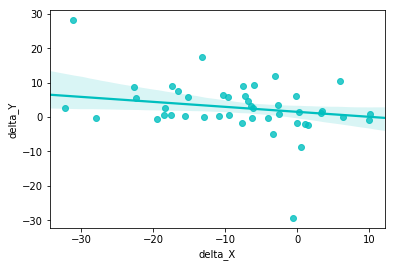

In [36]:
df2 = df.dropna(axis=0, subset=['delta_X'], inplace=False) # Drop the NaN on the first row for delta_X.#### Independent (x) axis is change in PTSD. An aggregate drop of 5-10 points is reliable (not due to chance). An aggregate drop of 10-20 is clinically meaningful. (Monson et al., 2008).
#### Dependent (y) axis is change in faith. 
n = df2.shape[1]
logger.info('X=change in PTSD; Y=change in faith. n=' + str(n))
stat.plot_and_stats(df=df2, xlabel='delta_X', ylabel='delta_Y', color='c')

## Analysis without zero response
#### Main equation: $y = -0.277x + 0.487$
#### $r^2 = 0.1308$
#### $p = 0.0147$
#### $standard error: 0.1088$
## Observations
$n=48$

## Interpretation
A lowering of PTSD scores is correlated with an increase in faith. For every 1 point increase in faith, an individual will enjoy a .277 point drop in PTSD scoring.
## Statistical significance
A p-value < 0.05 shows that the results are significant in the social studies domain.

# Further analysis

## Pie chart showing meaningful change
Remember, meaningful changes at $\Delta x \leq -5$ and $\Delta x \leq -10$.

Individual has not responded: $\Delta x \gt -5$

Individual has responded to treatment: $\Delta x \leq -5$

Clinically meaningful response: $\Delta x \leq -10$.


"clinically meaningful": 35.42 %
"individual has not responded to treatment": 37.50 %
"individual responded to treatment": 20.83 %


C:\Users\Owner\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


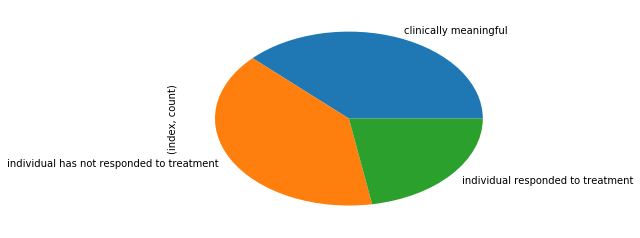

In [56]:
def find_response_category(deltaX):
    if deltaX <= -10.0:
        return 'clinically meaningful'
    elif deltaX <= -5.0:
        return 'individual responded to treatment'
    else:
        return 'individual has not responded to treatment'
    
df2['response'] = df2['delta_X'].apply(find_response_category)
# plt.pie(df2['response'])
responses = df2.groupby(df2['response']).agg(['count']).iloc[:,0]
responses.plot(kind='pie')
# print (responses.index)
labels = responses.index
counts = responses.values
for i in range(labels.size):
    # logger.debug('Response: %s has a count of %d.'% (labels[i], counts[i]))
    print ('"%s": %.2f %%'% (labels[i], (100.0 * counts[i]) / n))


## Were there changes dependent on age?


## Were the changes dependent on branch?

## Were the changes dependent on campaign?